# Khảo sát Năng lực triển khai dự án Phân tích dữ liệu

Chào các bạn học viên tại **CodeGym**, nhằm tìm hiểu sự hiệu quả trong quá trình giảng dạy, cũng như để biết được các bạn đang gặp khó khăn nào trong quá trình học, GV Tô Thanh Đức đã tạo ra mô phỏng dữ liệu doanh nghiệp để các bạn thực hành.

Ngữ cảnh: **Một công ty cần tạo 1 *báo cáo* để nắm bắt tình hình hoạt động Nhập/Xuất kho**.

Dữ liệu đầu vào: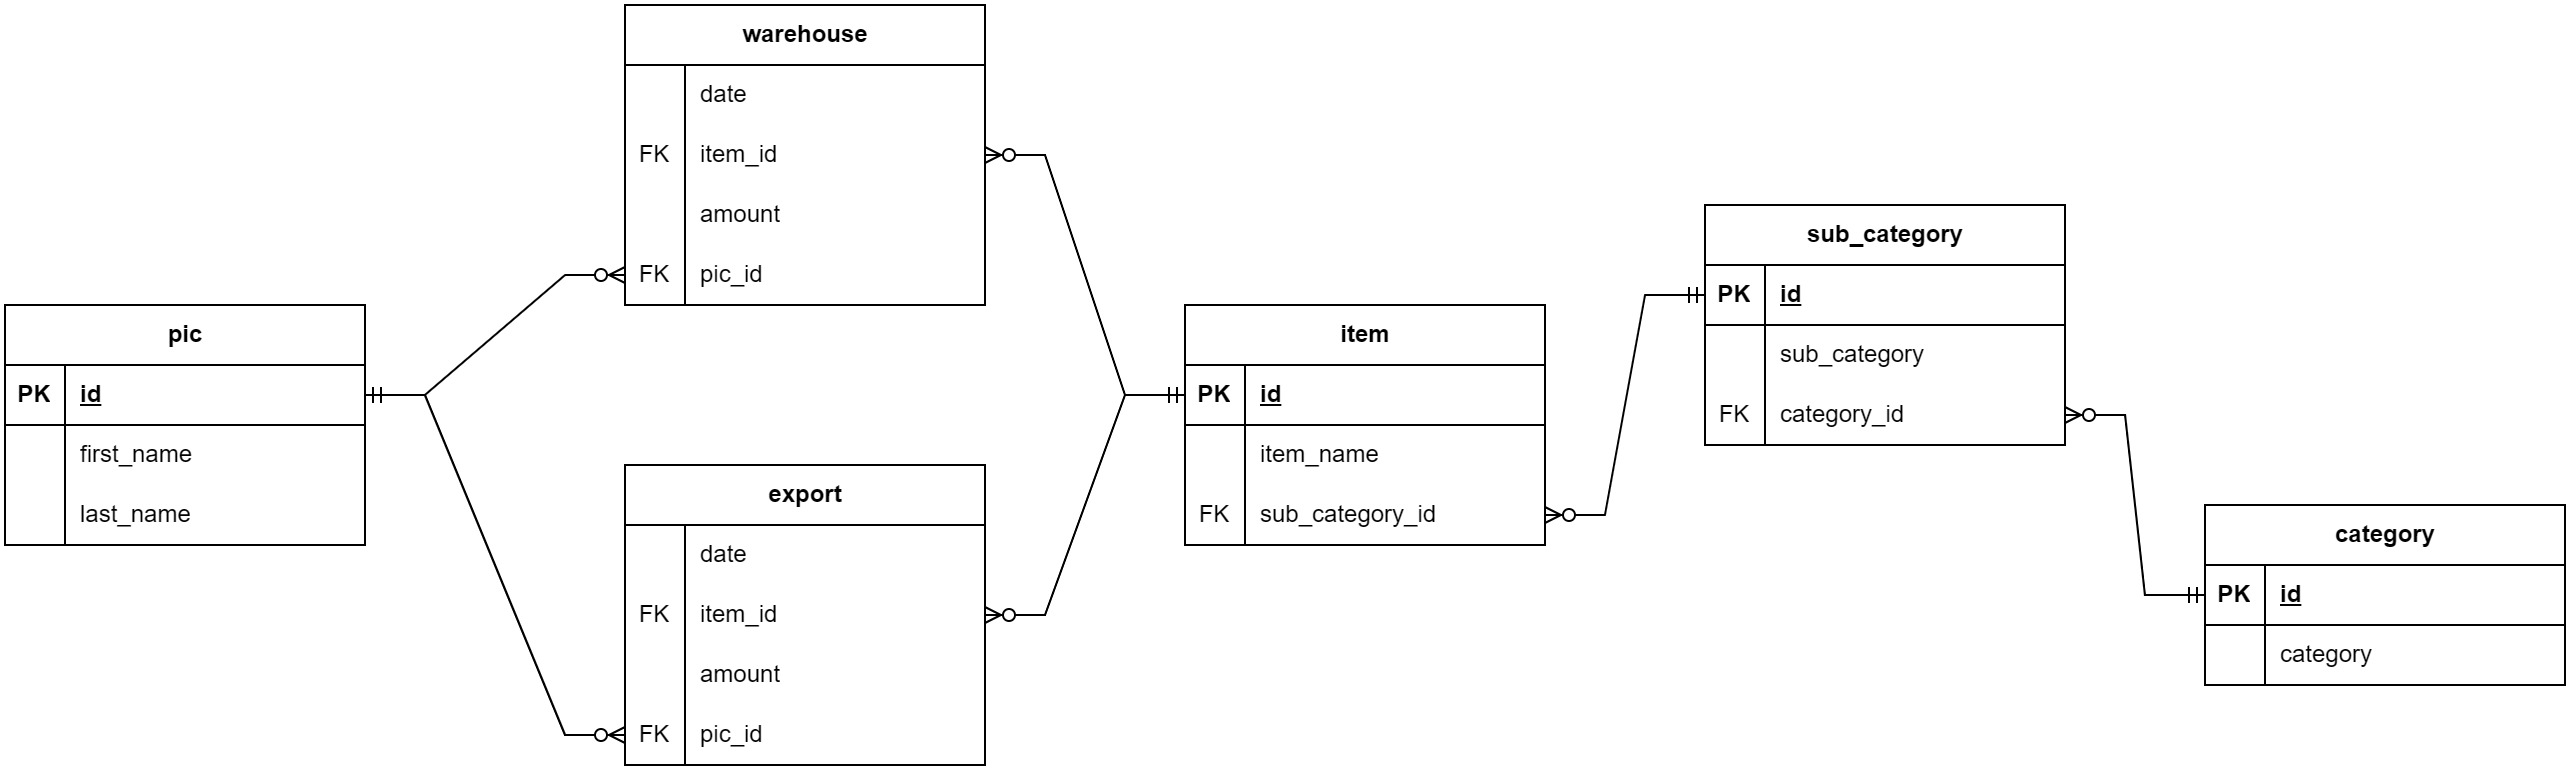

**warehouse: Bảng Nhập kho**
- date (int): ngày Nhập kho
- item_id (int): Mã sản phẩm Nhập kho
- amount (int): Khối lượng Nhập kho
- pic_id (int): Mã nhân viên phụ trách Nhập kho cho sản phẩm đó

**export: Bảng Xuất kho**
- date (int): ngày Xuất kho
- item_id (int): Mã sản phẩm Xuất kho
- amount (int): Khối lượng Xuất kho
- pic_id (int): Mã nhân viên phụ trách Xuất kho cho sản phẩm đó

**pic: Danh sách nhân viên**
- id (int): Mã nhân viên
- first_name (object): Tên nhân viên
- last_name (object): Họ nhân viên

**item: Danh sách mặt hàng**
- id (int): Mã mặt hàng
- item_name (object): Tên mặt hàng
- sub_category_id (int): Mã Loại hàng hóa Level 2

**sub_category: Danh sách Loại hàng hóa Level 2**
- id (int): Mã Loại hàng hóa Level 2
- sub_category (object): Tên Loại hàng hóa Level 2
- category_id (int): Mã Loại hàng hóa Level 1

**category: Danh sách Loại hàng hóa Level 1**
- id (int): Mã Loại hàng hóa Level 1
- category (object): Tên Loại hàng hóa Level 1

## Phần 1. Làm sạch Logic của data (mẫu)

**Lưu ý:** Học viên chạy toàn bộ code của Phần 1 trước khi làm các nội dung sau.

In [4]:
import pandas as pd
import numpy as np

### **Ô này lưu toàn bộ đường dẫn, tên sheet của các bảng trong file Excel**

In [5]:
data_path = 'C:\\Users\\EVN-PC\\Downloads\\'
data_name = 'warehouse_tracking.xlsx'

warehouse_sh = 'warehouse'
export_sh = 'export'
item_sh = 'item'
sub_category_sh = 'sub_category'
category_sh = 'category'
pic_sh = 'pic'

**Truy cập vào dữ liệu, tạo các Pandas objects**

In [6]:
warehouse_df = pd.read_excel(data_path + data_name, sheet_name = warehouse_sh)
warehouse_df.head()

,date,item_id,amount,pic_id
0,44562,1801,97,16
1,44562,337,945,33
2,44562,554,541,9
3,44562,1107,386,19
4,44562,273,286,58


In [7]:
export_df = pd.read_excel(data_path + data_name, sheet_name = export_sh)
export_df.head()

,date,item_id,amount,pic
0,44565,568,130,72
1,44565,1286,616,47
2,44565,864,485,27
3,44565,1040,518,72
4,44565,840,21,6


In [8]:
warehouse_df['date'] = pd.to_datetime(warehouse_df['date'] - 25569, unit = 'd')
export_df['date'] = pd.to_datetime(export_df['date'] - 25569, unit = 'd')

In [9]:
export_df.head()

,date,item_id,amount,pic
0,2022-01-04,568,130,72
1,2022-01-04,1286,616,47
2,2022-01-04,864,485,27
3,2022-01-04,1040,518,72
4,2022-01-04,840,21,6


In [10]:
warehouse_df.head()

,date,item_id,amount,pic_id
0,2022-01-01,1801,97,16
1,2022-01-01,337,945,33
2,2022-01-01,554,541,9
3,2022-01-01,1107,386,19
4,2022-01-01,273,286,58


In [11]:
# detect the 1st day in warehouse
wh_1st_day = warehouse_df.groupby(['item_id'])['date'].min().reset_index()
wh_1st_day.head()

,item_id,date
0,1,2022-07-07
1,2,2022-02-01
2,3,2022-02-04
3,4,2022-07-04
4,5,2022-02-11


In [12]:
# 1st warehouse_day merge to export
export_df = pd.merge(export_df, wh_1st_day
                     ,how = 'left'
                     ,on = ['item_id']
                     ,suffixes=('_ex', '_wh'))
export_df.head()

,date_ex,item_id,amount,pic,date_wh
0,2022-01-04,568,130,72,2022-01-01
1,2022-01-04,1286,616,47,2022-04-08
2,2022-01-04,864,485,27,2022-01-15
3,2022-01-04,1040,518,72,2022-07-06
4,2022-01-04,840,21,6,2022-03-17


In [13]:
date_valid_export_row_cond = export_df['date_ex'] >= export_df['date_wh']
date_valid_export_col_cond = ['date_ex', 'item_id', 'amount', 'pic']
date_valid_ex = export_df.loc[date_valid_export_row_cond, date_valid_export_col_cond].copy()
date_valid_ex.shape[0]

13890

In [14]:
date_valid_ex['item_id'].nunique()

1835

In [15]:
date_valid_ex.head()

,date_ex,item_id,amount,pic
0,2022-01-04,568,130,72
22,2022-01-04,830,591,59
32,2022-01-04,1210,846,60
70,2022-01-05,273,522,62
77,2022-01-05,1263,527,38


In [16]:
def detect_wrong_records(item_id, warehouse_df, export_df):
    # Lọc bảng Nhập kho từng item_id một
    wh_row_cond = warehouse_df['item_id'] == item_id
    wh_col_cond = ['date', 'item_id', 'amount']
    item_id_wh = warehouse_df.loc[wh_row_cond, wh_col_cond].copy()
    
    # Lọc bảng Xuất kho từng item_id một
    ex_row_cond = export_df['item_id'] == item_id
    ex_col_cond = ['date_ex', 'item_id', 'amount']
    item_id_ex = export_df.loc[ex_row_cond, ex_col_cond].copy()
    
    # Tổng hợp biến động Nhập/Xuất mỗi ngày (giả định đơn vị nhỏ nhất là Ngày)
    wh_by_date = item_id_wh.groupby(['date'])['amount'].sum().reset_index()
    ex_by_date = item_id_ex.groupby(['date_ex'])['amount'].sum().reset_index()
    
    # Tạo 1 bảng với 1 chuỗi ngày, từ Ngày Nhập kho Đầu tiên đến Ngày Xuất kho Cuối cùng
    all_date_ = pd.date_range(wh_by_date['date'].min(), ex_by_date['date_ex'].max()).tolist()
    all_date_df = pd.DataFrame({'all_date':all_date_})
    
    # Ghép số liệu Nhập kho vào bảng all_date
    all_date_df = pd.merge(all_date_df, wh_by_date
                          ,how = 'left'
                          ,left_on = ['all_date']
                          ,right_on = ['date']).loc[:,['all_date', 'amount']].copy()
    
    # Ghép số liệu Xuất kho vào bảng all_date
    all_date_df = pd.merge(all_date_df, ex_by_date
                          ,how = 'left'
                          ,left_on = ['all_date']
                          ,right_on = ['date_ex']
                          ,suffixes=('_wh', '_ex')).loc[:, ['all_date', 'amount_wh', 'amount_ex']].copy()
    
    # Bài toán không yêu cầu tính toán tồn kho "mỗi ngày",
    # nên những ngày không có record cần được loại bỏ
    all_date_df.dropna(subset = ['amount_wh', 'amount_ex'], how = 'all', inplace = True)
    
    # Thay thế tất cả giá trị rỗng bằng sô 0
    all_date_df.fillna(0, inplace = True)
    
    # Reset lại index của bảng all_date sau khi đã loại những ngày không record
    # Nhằm thuận tiện hơn cho for loop
    all_date_df.reset_index(drop = True, inplace = True)
    
    # Tạo 1 list rỗng chứa những ngày không hợp lệ
    invalid_date = []
    
    # Tạo 1 list rỗng chứa những khối lượng không hợp lệ
    invalid_amount = []
    
    # Tạo 1 biến đếm số lượng tồn kho, bắt đầu từ Ngày nhập kho đầu tiên
    stock = all_date_df['amount_wh'][0] - all_date_df['amount_ex'][0]
    
    # Dùng vòng for từ ngày thứ 2 kiểm tra điều kiện,
    # nếu khối lượng xuất kho lớn hơn tổng Tồn kho (stock) -> Invalid
    # khi xác định Invalid, Tồn kho chỉ đếm cộng dồn Nhập kho của ngày đó
    # đồng thời lưu lại giá trị Ngày Xuất kho, Khối lượng xuất không hợp lệ
    # Nếu khối lượng xuất kho nhỏ hơn tổng Tồn kho (stock) -> Valid
    # khi xác định Valid, Tồn kho đếm cộng dồn Nhập kho trừ Xuất kho của ngày đó
    for _ in range(1, all_date_df.shape[0]):
        if all_date_df['amount_ex'][_] > stock:
            stock += all_date_df['amount_wh'][_]
            invalid_date += [all_date_df['all_date'][_]]
            invalid_amount += [all_date_df['amount_ex'][_]]
        else:
            stock += all_date_df['amount_wh'][_] - all_date_df['amount_ex'][_]
    
    # Tạo 1 bảng chứa các records không hợp lệ
    wrong_records_df = pd.DataFrame({'invalid_date':invalid_date
                                     , 'invalid_amount':invalid_amount})
    
    # Xác định giá trị item_id cho bảng này luôn
    wrong_records_df['item_id'] = item_id
    return wrong_records_df

In [17]:
# Thư viện tqdm dùng để tạo 1 thanh tiến trình
# giúp nhận biết vòng for đang hoạt động
from tqdm import tqdm

# Tạo 1 bảng trống, chứa sẵn các cột sẽ được tạo ra trong bảng wrong_records_df
wrong_records = pd.DataFrame(columns = ['invalid_date', 'invalid_amount', 'item_id'])
for _ in tqdm(date_valid_ex['item_id'].unique().tolist()):
    wrong_records_each_id = detect_wrong_records(item_id = _
                                                 , warehouse_df = warehouse_df
                                                 , export_df = date_valid_ex)
    
    # Dùng pd.concat để nối các bảng có cùng tên cột
    wrong_records = pd.concat([wrong_records, wrong_records_each_id], ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████| 1835/1835 [00:10<00:00, 177.17it/s]


In [26]:
wrong_records

,invalid_date,invalid_amount,item_id
0,2022-06-02,863.0,568
1,2022-09-24,645.0,568
2,2022-11-23,628.0,568
3,2022-11-25,530.0,568
4,2022-01-08,771.0,830
...,...,...,...
5667,2022-12-02,776.0,1421
5668,2022-12-29,110.0,1776
5669,2022-12-21,996.0,326
5670,2022-12-22,856.0,1317


In [27]:
# Dùng pd.to_datetime để chỉnh lại cột 'invalid_date' về dạng datetime
wrong_records['invalid_date'] = pd.to_datetime(wrong_records['invalid_date'])

In [28]:
# Anti Join
# Ý tưởng từ Left Join, và chọn những dòng có giá trị là NaN ở bảng bên phải
date_amount_valid_ex = pd.merge(date_valid_ex, wrong_records
                         ,how = 'left'
                         ,left_on = ['date_ex','item_id']
                         ,right_on = ['invalid_date', 'item_id'])

In [29]:
date_amount_valid_ex

,date_ex,item_id,amount,pic,invalid_date,invalid_amount
0,2022-01-04,568,130,72,NaT,NaN
1,2022-01-04,830,591,59,NaT,NaN
2,2022-01-04,1210,846,60,NaT,NaN
3,2022-01-05,273,522,62,2022-01-05,522.0
4,2022-01-05,1263,527,38,NaT,NaN
...,...,...,...,...,...,...
13885,2022-12-31,1108,142,2,NaT,NaN
13886,2022-12-31,76,522,79,NaT,NaN
13887,2022-12-31,1773,738,72,2022-12-31,738.0
13888,2022-12-31,1599,384,6,2022-12-31,384.0


In [30]:
date_amount_valid_ex['invalid_amount'].isnull()

0         True
1         True
2         True
3        False
4         True
         ...  
13885     True
13886     True
13887    False
13888    False
13889     True
Name: invalid_amount, Length: 13890, dtype: bool

In [31]:
anti_cond = date_amount_valid_ex['invalid_amount'].isnull()
col_cond = ['date_ex', 'item_id', 'amount', 'pic']
date_amount_valid_ex = date_amount_valid_ex.loc[anti_cond, col_cond].copy().reset_index(drop = True)

In [32]:
date_amount_valid_ex

,date_ex,item_id,amount,pic
0,2022-01-04,568,130,72
1,2022-01-04,830,591,59
2,2022-01-04,1210,846,60
3,2022-01-05,1263,527,38
4,2022-01-06,554,274,28
...,...,...,...,...
8124,2022-12-31,201,302,70
8125,2022-12-31,1220,791,45
8126,2022-12-31,1108,142,2
8127,2022-12-31,76,522,79


*Và bây giờ ta đã có bảng **Xuất kho** được lưu với tên biến **date_amount_valid_ex** với dữ liệu đã được làm sạch Logic, sẵn sàng cho phân tích.*

## Phần 2. Phân tích dữ liệu (20 điểm)

#### 1. Truy cập vào các bảng **Dimension** và lưu vào Pandas Object *(1đ)*

In [104]:
item_df = pd.read_excel(data_path + data_name, sheet_name = item_sh)
item_df.head()

,item_name,id,sub_category_id
0,Bush Somerset Collection Bookcase,1,1
1,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",2,2
2,Self-Adhesive Address Labels for Typewriters b...,3,3
3,Bretford CR4500 Series Slim Rectangular Table,4,4
4,Eldon Fold 'N Roll Cart System,5,5


In [105]:
item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   item_name        1850 non-null   object
 1   id               1850 non-null   int64 
 2   sub_category_id  1850 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 43.5+ KB


In [107]:
sub_category_df = pd.read_excel(data_path + data_name, sheet_name = sub_category_sh)
sub_category_df.head()

,sub_category,id,category_id
0,Bookcases,1,1
1,Chairs,2,1
2,Labels,3,2
3,Tables,4,1
4,Storage,5,2


In [109]:
sub_category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sub_category  17 non-null     object
 1   id            17 non-null     int64 
 2   category_id   17 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 540.0+ bytes


In [110]:
category_df = pd.read_excel(data_path + data_name, sheet_name = category_sh)
category_df.head()

,category,id
0,Furniture,1
1,Office Supplies,2
2,Technology,3


In [112]:
category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  3 non-null      object
 1   id        3 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 180.0+ bytes


In [114]:
pic_df = pd.read_excel(data_path + data_name, sheet_name = pic_sh)
pic_df.head()

,id,first_name,last_name
0,1,Emily,Smith
1,2,James,Johnson
2,3,Sophia,Williams
3,4,Benjamin,Brown
4,5,Olivia,Jones


In [115]:
pic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          81 non-null     int64 
 1   first_name  81 non-null     object
 2   last_name   81 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.0+ KB


#### 2. Có bảng nào có dữ liệu rỗng (null) không? *(1đ)*

In [116]:
nan_value = item_df.replace(' ',np.nan)
nan_values = item_df[nan_value.isna().any(axis=1)]
nan_values

,item_name,id,sub_category_id


In [117]:
nan_value = sub_category_df.replace(' ',np.nan)
nan_values = sub_category_df[nan_value.isna().any(axis=1)]
nan_values

,sub_category,id,category_id


In [118]:
nan_value = category_df.replace(' ',np.nan)
nan_values = category_df[nan_value.isna().any(axis=1)]
nan_values

,category,id


In [119]:
nan_value = pic_df.replace(' ',np.nan)
nan_values = pic_df[nan_value.isna().any(axis=1)]
nan_values

,id,first_name,last_name


In [126]:
item_df.isnull().sum()

item_name          0
id                 0
sub_category_id    0
dtype: int64

In [125]:
category_df.isnull().sum()

category    0
id          0
dtype: int64

In [127]:
sub_category_df.isnull().sum()

sub_category    0
id              0
category_id     0
dtype: int64

In [128]:
pic_df.isnull().sum()

id            0
first_name    0
last_name     0
dtype: int64

#### 3. Sản phẩm nào được nhập kho **nhiều lần nhất**? *(1đ)*

In [76]:
most_wh_item = warehouse_df.groupby(['item_id'])['date'].count().reset_index()
most_wh_item.max()

item_id    1850
date         15
dtype: int64

#### 4. Sản phẩm nào **có khối lượng xuất kho lớn nhất** ? *(1đ)*

In [98]:
most_ex_item = result.groupby(['item_id'])['amount'].max().reset_index()
most_ex_item.nlargest(10,'amount')

,item_id,amount
1164,1193,1000
1190,1219,1000
108,114,999
130,136,999
614,631,999
282,291,998
828,853,998
836,861,998
1465,1500,998
1564,1602,998


#### 5. Ngày nào phải nhập nhiều hàng nhất? *(1đ)*

In [102]:
most_wh_date =warehouse_df.groupby(['date'])['item_id'].count().reset_index()
most_wh_date.nlargest(1,'item_id')

,date,item_id
279,2022-10-07,45


#### 6. Tên đầy đủ của nhân viên Nhập hàng nhiều lần nhất, người đó đã xuất hàng bao nhiêu lần? *(2đ)*

In [157]:
pic_df['full_name'] = pic_df['first_name'] + " " + pic_df['last_name']

df_pic_fullname = pd.merge(date_amount_valid_ex, pic_df
                         ,how = 'left'
                         ,left_on = ['pic']
                        ,right_on = ['id']).loc[:,['date_ex', 'item_id','pic','full_name']].copy()
df_pic_fullname.reset_index()

,index,date_ex,item_id,pic,full_name
0,0,2022-01-04,568,72,Skylar Foster
1,1,2022-01-04,830,59,Nicholas Diaz
2,2,2022-01-04,1210,60,Claire Hayes
3,3,2022-01-05,1263,38,Chloe Evans
4,4,2022-01-06,554,28,Christopher Adams
...,...,...,...,...,...
8124,8124,2022-12-31,201,70,Layla Bradley
8125,8125,2022-12-31,1220,45,Andrew Cook
8126,8126,2022-12-31,1108,2,James Johnson
8127,8127,2022-12-31,76,79,Riley Hamilton


In [167]:
most_pic_ex = df_pic_fullname.groupby[('full_name')]['date_ex'].sum().reset_index()
most_pic_ex.nlargest(5,'date_ex')

TypeError: 'method' object is not subscriptable

#### 7. Category nào được nhập hàng với khối lượng lớn nhất, trong Category đó sản phẩm nào được xuất đi với khối lượng lớn nhất? *(2đ)*

#### 8. Trong tháng đầu tiên, Sub-category **Binders** được Nhập kho bởi những nhân viên nào? *(3đ)*

#### 9. Vào ngày cuối cùng của tháng 5, sub-category **Tables** còn bao nhiêu hàng trong kho? *(4đ)*

#### 10. Những sản phẩm nào **chưa từng được xuất kho**? *(4đ)*